In [ ]:
# Analysing data set

import pandas as pd
import numpy as np
from scipy.interpolate import splev, splprep
import datashader as ds
import colorcet as cc
import matplotlib.pyplot as plt
import seaborn as sns
import openrouteservice as ors
from openrouteservice import directions
import time

In [3]:
df = pd.read_csv('Daily_Data_EV.csv')

In [ ]:
# split departure time into separate columns (2) for hours and minutes
df_time_split = df['departure_time'].str.split(pat=':',expand=True).astype(int)

# converting hour-minute format to float and joining back into one number
    # int value + 0. decimal value
time_num_decimal =  df_time_split[0] + df_time_split[1]/60

# put time decimal into pandas dataframe to join back with original
df_time_decimal = pd.DataFrame({'time_decimal':time_num_decimal})
df_time_int = pd.DataFrame({'time_int':df_time_split[0]})

# joining new column with time decimal and int with main dataframe
df = df.join(df_time_decimal).join(df_time_int)

Text(0.5, 0, 'Time (h)')

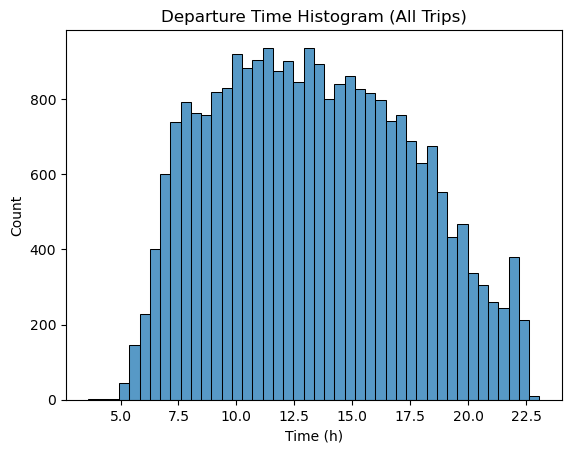

In [323]:
# histogram
sns.histplot(df["time_decimal"])
plt.title("Departure Time Histogram (All Trips)")
plt.xlabel("Time (h)")

In [5]:
# separating dataset with only EV-#, Trip, Departure Time and Decimal Time
cleaned_df = df[['EV Number', 'Trip', 'departure_time', 'time_decimal', 'time_int', 't_dist']]

# splitting coordinate cells by ',' into separate latitude and longitude columns for source and destination
    # remember to convert into float
source_df = df['source'].str.split(pat=",", expand=True).astype('float32')
destination_df = df['destination'].str.split(pat=",", expand=True).astype('float32')

# joining back into separate columns
cleaned_df = pd.concat([cleaned_df, source_df, destination_df], axis=1)

# renaming columns
cleaned_df.columns = ['EV_Number', 'Trip','departure_time', 'time_decimal', 'time_int', 'distance', 'source_lat', 'source_lon', 'destination_lat', 'destination_lon']

cleaned_df.head(10)


,EV_Number,Trip,departure_time,time_decimal,time_int,distance,source_lat,source_lon,destination_lat,destination_lon
0,EV-1,1_8,06:35,6.583333,6,1.878,36.044201,-86.730103,36.047298,-86.714104
1,EV-1,8_2,06:59,6.983333,6,27.165,36.047298,-86.714104,36.057201,-86.977997
2,EV-1,2_2,08:15,8.250000,8,42.277,36.057201,-86.977997,36.277302,-86.818604
3,EV-1,2_8,09:15,9.250000,9,19.548,36.277302,-86.818604,36.189499,-86.729202
4,EV-1,8_2,11:45,11.750000,11,15.729,36.189499,-86.729202,36.151600,-86.844398
5,EV-1,2_12,12:01,12.016667,12,10.877,36.151600,-86.844398,36.133400,-86.766998
6,EV-1,12_1,15:21,15.350000,15,16.534,36.133400,-86.766998,36.134399,-86.633003
7,EV-2,1_2,07:54,7.900000,7,61.727,36.124199,-86.545197,36.315701,-86.867996
8,EV-2,2_6,18:47,18.783333,18,45.226,36.315701,-86.867996,36.042198,-86.745598
9,EV-2,6_6,19:40,19.666667,19,20.621,36.042198,-86.745598,36.174500,-86.750900


Text(0.5, 1.0, 'Distance Traveled Histogram (All Trips)')

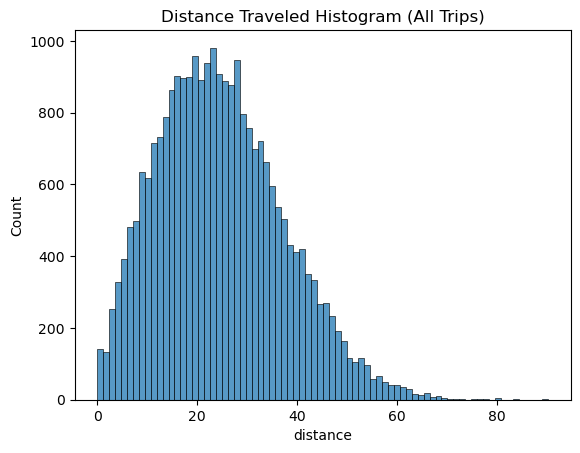

In [318]:
sns.histplot(cleaned_df["distance"])
plt.title("Distance Traveled Histogram (All Trips)")

In [6]:
def get_coord_df(ev_set):
    # merging source and destination into one series so they are connected in order when graphed
    ev_source = ev_set[['source_lat', 'source_lon']]
    ev_destination = ev_set[['destination_lat', 'destination_lon']]

    # realization: every source is the destination of the previous trip, except for the first one (and last)
    # just need append destination one row to source and join the datasets

    # getting last row of destination
    last_row = ev_destination.iloc[-1]
    # renaming labels to match source df when concatenating so index match on concatenation
    last_row.index = ev_source.columns

    # appending last row to end with concatenate (taking transpose of row)
    return_df = pd.concat([ev_source,last_row.to_frame().T], axis=0, ignore_index=True)
    return_df.columns = ['lat', 'lon']

    return return_df

In [91]:
# Getting map coordinate boundaries
coord_df = get_coord_df(cleaned_df)

# 0 is 3 o'clock, 1 is 6 o'clock, 2 is 9 o'clock, 3 is 12 o'clock
box_boundaries = [coord_df['lon'].max(), coord_df['lat'].min(), coord_df['lon'].min(), coord_df['lat'].max()]

box_boundaries

[-86.51969909667969, 35.982398986816406, -87.04309844970703, 36.38169860839844]

In [92]:
coord_df

,lat,lon
0,36.044201,-86.730103
1,36.047298,-86.714104
2,36.057201,-86.977997
3,36.277302,-86.818604
4,36.189499,-86.729202
...,...,...
25852,36.035702,-86.961899
25853,36.268700,-86.702400
25854,36.072701,-86.925102
25855,36.046600,-86.721703


In [182]:
# Separating dataset into morning
morning_cleaned_df = cleaned_df[cleaned_df['time_decimal']<10]

# Separating dataset into midday
midday_cleaned_df = cleaned_df[(cleaned_df['time_decimal']>=10) & (cleaned_df['time_decimal']<17)]

# Separating dataset into evening
evening_cleaned_df = cleaned_df[(cleaned_df['time_decimal']>=17)]

# defining python dict for ease of access
df_blocks = {
    "morning": {
        "name": "morning",
        "dataframe": morning_cleaned_df
        },
    "midday": {
        "name": "midday",
        "dataframe": midday_cleaned_df
        },
    "evening": {
        "name": "evening",
        "dataframe": evening_cleaned_df
        }
}

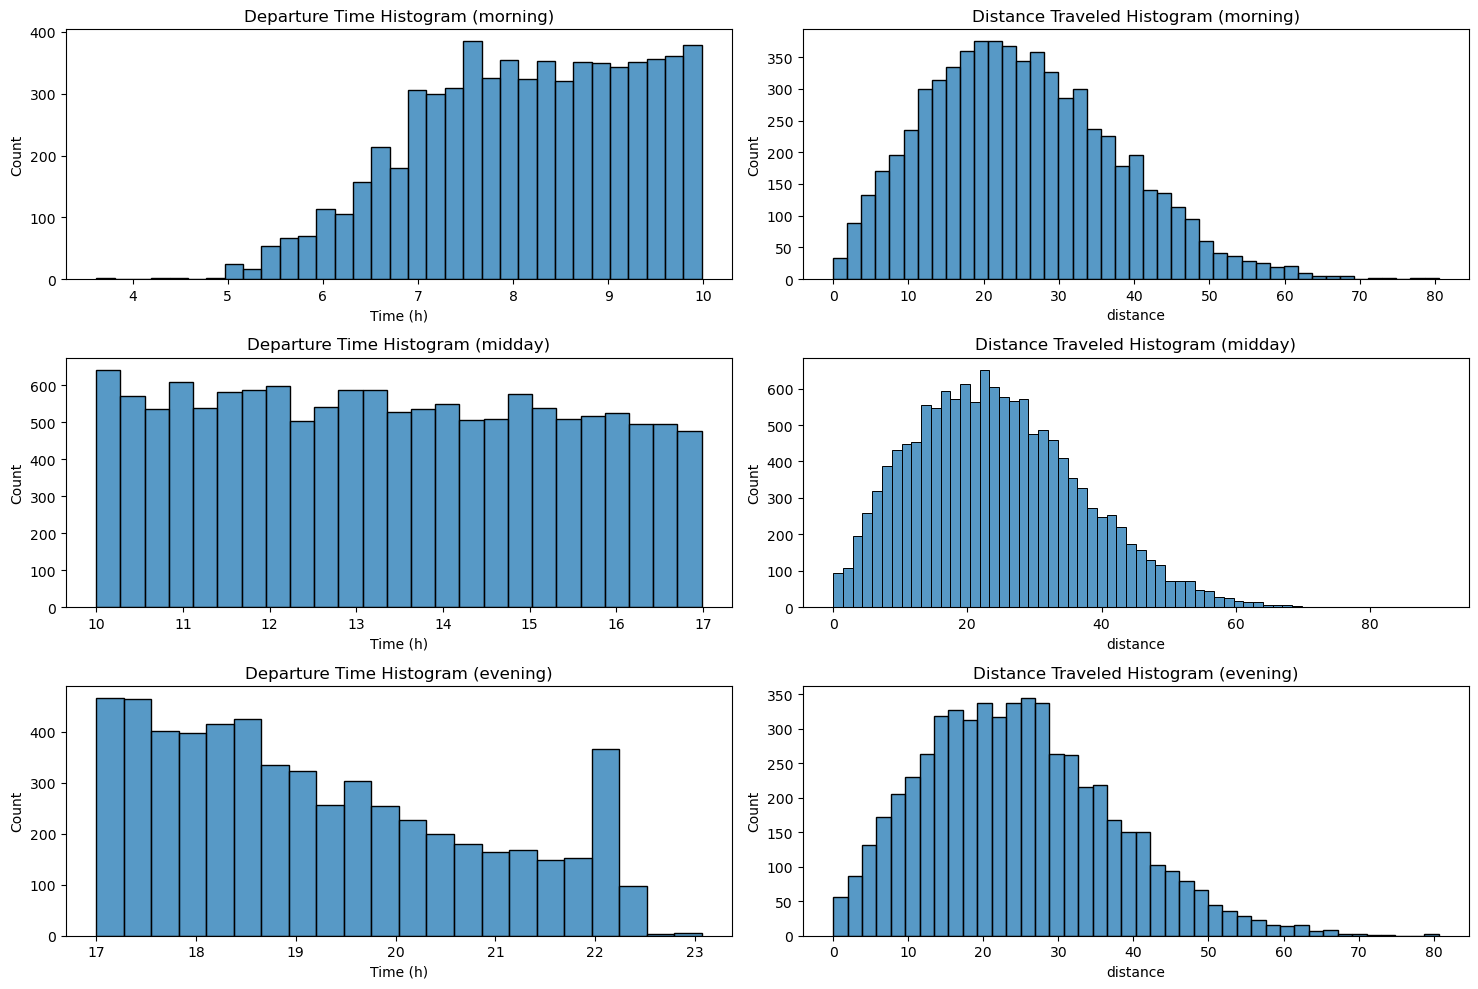

In [ ]:
# Show Departure Time Histogram for 3 time blocks

block_plot_index = 1

plt.figure(figsize=(15, 10))

for block in df_blocks:
    df = df_blocks[block]["dataframe"]

    # time histogram
    plt.subplot(3, 2, block_plot_index)
    plt.tight_layout()
    sns.histplot(df["time_decimal"])
    plt.title("Departure Time Histogram ({name})".format(name=block))
    plt.xlabel("Time (h)")

    block_plot_index = block_plot_index + 1

    # distance histogram
    plt.subplot(3, 2, block_plot_index)
    plt.tight_layout()
    sns.histplot(df["distance"])
    plt.title("Distance Traveled Histogram ({name})".format(name=block))

    block_plot_index = block_plot_index + 1

plt.show()

In [181]:
ev1_cleaned_df = cleaned_df[cleaned_df["EV_Number"]=="EV-1"]

# merging source and destination into one series so they are connected in order when graphed
ev1_source = ev1_cleaned_df[['source_lat', 'source_lon']]
ev1_destination = ev1_cleaned_df[['destination_lat', 'destination_lon']]

# realization: every source is the destination of the previous trip, except for the first one
# just need shift by one row and join the datasets

# getting last row of destination
last_row = ev1_destination.iloc[-1]
# renaming labels to match source df when concatenating
last_row.index = pd.Index(['lat', 'lon'])
ev1_source.columns = pd.Index(['lat', 'lon'])

ev1_coord_df = pd.concat([ev1_source,last_row.to_frame().T], axis=0, ignore_index=True)

# reversing because OpenRouteService API expects in (lon, lat) format
ev1_coord_list = ev1_coord_df.values.tolist()
# list comprehension reversing items in coordinate pair 
ev1_coord_list = [list(reversed(coord_pair)) for coord_pair in ev1_coord_list]
ev1_coord_list

[[-86.7301025390625, 36.0442008972168],
 [-86.71410369873047, 36.047298431396484],
 [-86.97799682617188, 36.05720138549805],
 [-86.818603515625, 36.27730178833008],
 [-86.72920227050781, 36.18949890136719],
 [-86.84439849853516, 36.1515998840332],
 [-86.76699829101562, 36.133399963378906],
 [-86.63300323486328, 36.1343994140625]]

In [7]:
# Accessing OpenRouteService API to get a route for the coordinates of EV1

test_coordinates = ((8.34234,48.23424),(8.34423,48.26424))

# passing key
# client = ors.Client(key='eyJvcmciOiI1YjNjZTM1OTc4NTExMTAwMDFjZjYyNDgiLCJpZCI6ImZhOGU1ZWU3MzUzNjQ5ODZiYzBjMDA1NTdkMTRhMDEyIiwiaCI6Im11cm11cjY0In0=')

client = ors.Client(base_url='http://localhost:8080/ors')


### EV 1 Route Template

In [ ]:
# measuring time for one
ev1_start_time = time.time()

# ----------------------

# getting route from API, returns list with coordinate pair list
route = client.directions(ev1_coord_list, profile="driving-car", format="geojson")["features"][0]["geometry"]["coordinates"]

# putting list into pandas dataframe
ev1_route_df = pd.DataFrame(route, columns=['lon', 'lat'])

# plotting in matplotlib
plt.figure(figsize=(5,5))
plt.tight_layout()
ax = sns.lineplot(data=ev1_route_df, x='lon', y='lat', sort=False, lw=3, estimator=None)
plt.axis('off')

# # aesthetics
# ax.set_title("EV-1 Trip")

ev1_end_time = time.time()
ev1_elapsed_time = ev1_end_time - ev1_start_time

plt.savefig("ev-1-route-test.png", dpi=100)
plt.close()

#-----------------------

print("Elapsed Time(s): {elap}".format(elap=round(ev1_elapsed_time,2)))

Elapsed Time(s): 0.17


[-86.729972, 36.044238]

In [8]:
def get_coord_list(df):
    # putting into list because OpenRouteService expects list/tuple
        # ex: [[34.52, -89.34], [34.23, -89.43], [34.56, -89.03]]
    coord_list = df.values.tolist()

    # list comprehension reversing items in coordinate pair 
    # reversing items because OpenRouteService API expects in (lon, lat) format and not (lat, lon)
        # ex: [[-89.34, 34.52, ], [-89.43, 34.23], [-89.03, 34.56]]
    coord_list = [list(reversed(coord_pair)) for coord_pair in coord_list]

    return coord_list

In [112]:
# get coordinates by time range
    # filter df by time range
    # get route for every motif / row in df
    # append (coords, dept time) to coord list

# can pretty much ignore EV number

"""
returns points in df for time range (inclusive, exclusive]
    like 14:00 to 15:00 (up to 15:00, not included)
"""
def get_points(df, time_range, err=False):
    range_df = df[(df["time_int"] >= time_range[0]) & (df["time_int"] < time_range[1])]

    # 3d list - [lon, lat, time]
        # ex: [[34.52, -89.34, 6], [34.23, -89.43, 7], [34.56, -89.03, 9]]
    list_used = []

    error_coords = []

    for row in range_df.itertuples():
        depart_time = row.time_int
        ev_num = row.EV_Number
        coords_pair = [[row.source_lon, row.source_lat],[row.destination_lon, row.destination_lat]]

        # getting route from API, returns list with coordinate pair list
            # returns something similar to input (ex just above) except with more datapoints
        try:
            # api call to OpenRouteService 
            api_response = client.directions(coords_pair, profile="driving-car", format="geojson")
            # getting just coordinates from simulated path
            route_coord_list = api_response["features"][0]["geometry"]["coordinates"]

            ## Recalculating path so coordinates are evenly distributed along the path ##
            
            # converting to np array and splitting coords into lon and lat
                # note: np.array [:,0] comma - grabs all first elems of all elem in second array
                    # returns [-89.234, -89.2423, -89.5432, etc...]
                # different from expected [:][0] - from all el in first array grab first elem (happens to be arr)
                    # returns [-89.234, 36.543]
            lon = np.array(route_coord_list)[:,0]
            lat = np.array(route_coord_list)[:,1]

            # calculating b-spline along the points of returned path
            tck, u = splprep([lon, lat], s=0)

            # recalculating points along line with new parameter values evenly spaced out
            new_u = np.linspace(0, 1, 100) # 50 points generated, 50 good enough for ~all routes based on random testing
            
            # returns 50 new longitude and latitude coordinates along simulated path
            new_lon, new_lat = splev(new_u, tck)

            ##  --------------------------------------------------------------------- ##                                               

            # append coordinate list to master points list
                # new_lon and new_lat must be same size (should be)
            for i in range(len(new_lon)):
                list_used.append([new_lon[i], new_lat[i], depart_time])

        except ors.exceptions.ApiError as e:
            # catching errors for unreachable routes (mostly ev's that stopped inside airports etc., negligible)
            api_error_code = e.args[0]
            ors_error_code = e.args[1]["error"]["code"]
            ors_error_msg = e.args[1]["error"]["message"]
            if err:
                print("API Error: ", api_error_code)
                print("Error Code: ", ors_error_code)
                print("EV Number: ", ev_num)
                print("Message: ", ors_error_msg)
                print()
        except Exception as e:
            # catching splprep errors for odd datapoints with same source and destination (i.e., near 0 distance travelled)
            if err:
                print("Error: ", e)
                print("EV Number: ", ev_num)
                print()

        
    return list_used

In [35]:

df_3 = cleaned_df[cleaned_df["EV_Number"]=="EV-3"]

value_arr = cleaned_df.iloc[533].tolist()
coords_pair_3 = [[float(value_arr[7]), float(value_arr[6])], [float(value_arr[9]), float(value_arr[8])]]

api_response_3 = client.directions(coords_pair_3, profile="driving-car", format="geojson")
route_coord_list_3 = api_response_3["features"][0]["geometry"]["coordinates"]

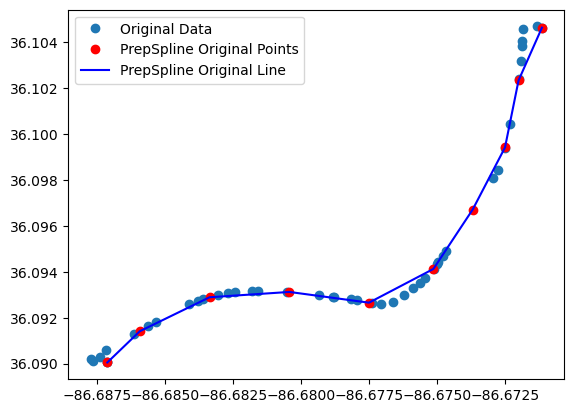

In [72]:

df_3 = cleaned_df[cleaned_df["EV_Number"]=="EV-3"]

value_arr = cleaned_df.iloc[14].tolist()
coords_pair_3 = [[float(value_arr[7]), float(value_arr[6])], [float(value_arr[9]), float(value_arr[8])]]

api_response_3 = client.directions(coords_pair_3, profile="driving-car", format="geojson")
route_coord_list_3 = api_response_3["features"][0]["geometry"]["coordinates"]

# splitting into x and y 
x_unsorted = np.array(route_coord_list_3)[:,0]
y_unsorted = np.array(route_coord_list_3)[:,1]

# prep
new_t = np.linspace(0, 1, 10)
new_tck, u = splprep([x_unsorted, y_unsorted], s=0)
new_points = splev(new_t, new_tck)

# Plot the original data and the smoothed spline
plt.plot(x_unsorted, y_unsorted, 'o', label='Original Data')
plt.plot(new_points[0], new_points[1], 'ro', label='PrepSpline Original Points')
plt.plot(new_points[0], new_points[1], 'b-', label='PrepSpline Original Line')
plt.legend()
plt.show()

In [93]:
cleaned_df[cleaned_df["EV_Number"]=="EV-4118"]

,EV_Number,Trip,departure_time,time_decimal,time_int,distance,source_lat,source_lon,destination_lat,destination_lon
15110,EV-4118,4_4,06:15,6.250000,6,14.386,36.172401,-86.762001,36.161301,-86.886497
15111,EV-4118,4_4,06:54,6.900000,6,18.760,36.161301,-86.886497,36.098598,-86.738503
15112,EV-4118,4_4,07:00,7.000000,7,14.739,36.098598,-86.738503,36.131699,-86.820198
15113,EV-4118,4_4,07:34,7.566667,7,0.000,36.131699,-86.820198,36.131699,-86.820198
15114,EV-4118,4_1,08:13,8.216667,8,18.133,36.131699,-86.820198,36.070400,-86.710999
15115,EV-4118,1_4,14:52,14.866667,14,17.095,36.070400,-86.710999,36.172401,-86.762001
15116,EV-4118,4_4,15:20,15.333333,15,11.606,36.172401,-86.762001,36.152302,-86.841904
15117,EV-4118,4_4,16:37,16.616667,16,7.580,36.152302,-86.841904,36.156700,-86.783096
15118,EV-4118,4_4,16:49,16.816667,16,14.538,36.156700,-86.783096,36.166801,-86.666199
15119,EV-4118,4_4,17:00,17.000000,17,19.102,36.166801,-86.666199,36.186798,-86.793098


In [189]:
ds_points_6 = get_points(cleaned_df, [0,7], err=True)

API Error:  404
Error Code:  2010
EV Number:  EV-90
Message:  Could not find routable point within a radius of 400.0 meters of specified coordinate 0: -86.9037018 36.1936989.

API Error:  404
Error Code:  2010
EV Number:  EV-153
Message:  Could not find routable point within a radius of 400.0 meters of specified coordinate 0: -86.9037018 36.1936989.

Error:  m > k must hold
EV Number:  EV-214

API Error:  404
Error Code:  2010
EV Number:  EV-1092
Message:  Could not find routable point within a radius of 400.0 meters of specified coordinate 0: -86.5339966 36.1021004.

API Error:  404
Error Code:  2010
EV Number:  EV-1136
Message:  Could not find routable point within a radius of 400.0 meters of specified coordinate 0: -86.9037018 36.1936989.

API Error:  404
Error Code:  2010
EV Number:  EV-1396
Message:  Could not find routable point within a radius of 400.0 meters of specified coordinate 0: -86.5339966 36.1021004.

API Error:  404
Error Code:  2010
EV Number:  EV-2264
Message:  Could

,

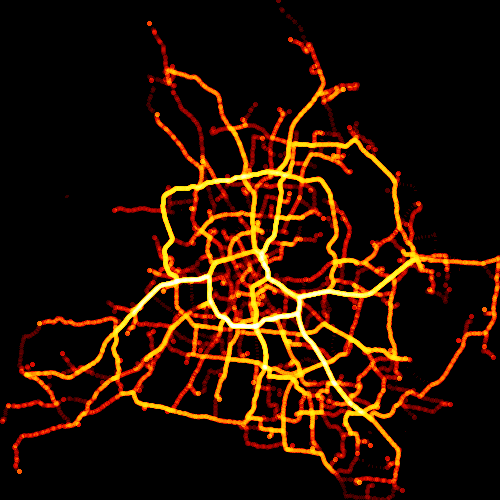
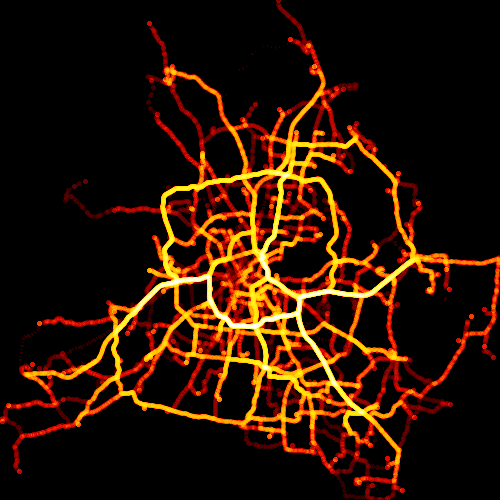

In [ ]:
ds_points_6 = get_points(cleaned_df, [0,8])

# putting returned array into dataframe
augmented_points_df_6 = pd.DataFrame(ds_points_6, columns=['lon', 'lat', 'time_int'])

# setting the time_int column as category type (necessary for Datashade 3D aggregation by time dimension)
augmented_points_df_6['time_int'] = augmented_points_df_6['time_int'].astype('category')

# creating canvas
ds_canvas_6 = ds.Canvas(plot_width=500, plot_height=500)

# making aggregate array
agg_6 = ds_canvas_6.points(augmented_points_df_6, 'lon', 'lat', ds.by('time_int', ds.count()))

# shading original image with black background
img_6 = ds.tf.set_background(ds.tf.shade(ds.tf.spread(agg_6.sel(time_int=6), px=2), cmap=cc.fire), "black")
img_7 = ds.tf.set_background(ds.tf.shade(ds.tf.spread(agg_6.sel(time_int=7), px=2), cmap=cc.fire), "black")

# displaying both images next to each other
ds.tf.Images(img_6, img_7)

In [116]:
ds_points_6 = get_points(cleaned_df, [0,24])

In [ ]:
# putting returned array into dataframe
augmented_points_df_6 = pd.DataFrame(ds_points_6, columns=['lon', 'lat', 'time_int'])

# setting the time_int column as category type (necessary for Datashade 3D aggregation by time dimension)
augmented_points_df_6['time_int'] = augmented_points_df_6['time_int'].astype('category')

# creating canvas
ds_canvas_6 = ds.Canvas(plot_width=500, plot_height=500)

# making aggregate array
agg_6 = ds_canvas_6.points(augmented_points_df_6, 'lon', 'lat', ds.by('time_int', ds.count()))

# shading original image with black background
img_6 = ds.tf.set_background(ds.tf.shade(ds.tf.spread(agg_6.sel(time_int=23), px=1), cmap=cc.fire), "black")

cat_to_shade = augmented_points_df_6["time_int"].cat.categories

shade_imgs = []

for cat in cat_to_shade:
    img_name = "hour-{}".format(cat)
    save_path = "./routes-generated/bspline/"
    img = ds.tf.set_background(ds.tf.shade(ds.tf.spread(agg_6.sel(time_int=cat), px=1), cmap=cc.fire), "black")
    ds.utils.export_image(img, filename=img_name, export_path=save_path)


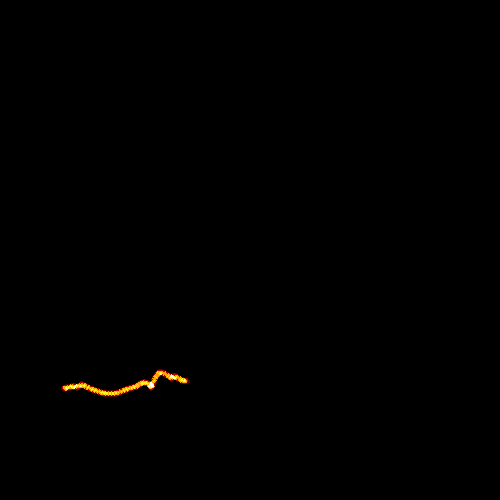

In [180]:
ds.tf.set_background(ds.tf.shade(ds.tf.spread(agg_6.sel(time_int=3), px=3), cmap=cc.fire), "black")

In [143]:
augmented_points_df_6["time_int"].cat.categories

Index([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23],
      dtype='int64')